# Drug Related Overdose Deaths
## Individual Project- Regression
### Natasha Rivers
#### July 14, 2021

<hr style="border:1px solid black"> </hr>

## Project Scope

**Methodology Used**: Regression

**Target Variable**: Age

**Primary Question**: Does age play a role in drug related deaths?

<hr style="border:1px solid black"> </hr>

## Executive Summary

- There is not a single indicator of what causes drug related deaths.
- OLS model performed best. Outperforming baseline, LassoLars and TweedieRegressor models

|Model                                | rmse_train   | rmse_validate  | r^2
|-------------------------------------|--------------|----------------|---------
|mean_baseline                        | 12.240       | 12.536         | 0.000
|OLS                                  | 12.119       | 12.381         | 0.024
|LassoLars (alpha 2)                  | 12.240       | 12.536         | 0.000
|TweedieRegressor (power 1, alpha 2)  | 12.121       | 12.384         | 0.024


<hr style="border:3px solid black"> </hr>

# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#custom modules
import acquire
import prepare

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import mean_squared_error, explained_variance_score

<hr style="border:2px solid black"> </hr>

# Acquire

In [2]:
#function from acquire.py
df = acquire.od_deaths_df()

In [3]:
df.head()

,Unnamed: 0,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,...,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,MannerofDeath,DeathCityGeo,ResidenceCityGeo,InjuryCityGeo
0,0,14-0273,06/28/2014 12:00:00 AM,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,Accident,"CT\n(41.575155, -72.738288)","CT\n(41.575155, -72.738288)","CT\n(41.575155, -72.738288)"
1,1,13-0102,03/21/2013 12:00:00 AM,0.0,48.0,Male,Black,NORWALK,NaN,NaN,...,0,0,0,NaN,0,0,Accident,"Norwalk, CT\n(41.11805, -73.412906)","NORWALK, CT\n(41.11805, -73.412906)","CT\n(41.575155, -72.738288)"
2,2,16-0165,03/13/2016 12:00:00 AM,0.0,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,...,0,0,0,NaN,0,1,Accident,"Danbury, CT\n(41.393666, -73.451539)","SANDY HOOK, CT\n(41.419998, -73.282501)",NaN
3,3,16-0208,03/31/2016 12:00:00 AM,0.0,23.0,Male,White,RYE,WESTCHESTER,NY,...,0,0,0,NaN,0,1,Accident,"Greenwich, CT\n(41.026526, -73.628549)",NaN,NaN
4,4,13-0052,02/13/2013 12:00:00 AM,0.0,22.0,Male,"Asian, Other",FLUSHING,QUEENS,NaN,...,0,0,0,NaN,0,0,Accident,"Greenwich, CT\n(41.026526, -73.628549)",NaN,"CT\n(41.575155, -72.738288)"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5105 entries, 0 to 5104
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           5105 non-null   int64  
 1   ID                   5105 non-null   object 
 2   Date                 5103 non-null   object 
 3   DateType             5103 non-null   float64
 4   Age                  5102 non-null   float64
 5   Sex                  5099 non-null   object 
 6   Race                 5092 non-null   object 
 7   ResidenceCity        4932 non-null   object 
 8   ResidenceCounty      4308 non-null   object 
 9   ResidenceState       3556 non-null   object 
 10  DeathCity            5100 non-null   object 
 11  DeathCounty          4005 non-null   object 
 12  Location             5081 non-null   object 
 13  LocationifOther      590 non-null    object 
 14  DescriptionofInjury  4325 non-null   object 
 15  InjuryPlace          5039 non-null   o

### Takeaways from Acquire:
- imported the csv into Pandas and created a dataframe
- original dataframe contains:
    - 41 columns 
        - multiple data types
    - 5105 entries
- will likely need to:
    - drop some columns
    - rename columns
    - change data types
- dummies already appear to have been created
- contains many nulls

<hr style="border:2px solid black"> </hr>

# Prepare

In [5]:
#look into nulls
df.isnull().sum()

Unnamed: 0                0
ID                        0
Date                      2
DateType                  2
Age                       3
Sex                       6
Race                     13
ResidenceCity           173
ResidenceCounty         797
ResidenceState         1549
DeathCity                 5
DeathCounty            1100
Location                 24
LocationifOther        4515
DescriptionofInjury     780
InjuryPlace              66
InjuryCity             1756
InjuryCounty           2741
InjuryState            3681
COD                       0
OtherSignifican        4936
Heroin                    0
Cocaine                   0
Fentanyl                  0
Fentanyl_Analogue         0
Oxycodone                 0
Oxymorphone               0
Ethanol                   0
Hydrocodone               0
Benzodiazepine            0
Methadone                 0
Amphet                    0
Tramad                    0
Morphine_NotHeroin        0
Hydromorphone             0
Other               

In [6]:
#look into variations of manner of death
df.MannerofDeath.value_counts()

Accident    5066
Pending       14
accident      13
Natural        1
ACCIDENT       1
Name: MannerofDeath, dtype: int64

In [7]:
#look into Race combinations being represented
df.Race.value_counts()

White                     4004
Hispanic, White            561
Black                      433
Hispanic, Black             24
Unknown                     23
Asian, Other                18
Asian Indian                14
Other                       11
Chinese                      2
Hawaiian                     1
Native American, Other       1
Name: Race, dtype: int64

In [8]:
df = prepare.prep_set(df)

In [9]:
df.head()

,Date,Age,Sex,Race,ResidenceCity,DeathCity,Location,DescriptionofInjury,InjuryPlace,COD,...,Morphine_NotHeroin,Hydromorphone,OpiateNOS,AnyOpioid,MannerofDeath,Black,Hispanic,Other,Unknown,White
0,06/28/2014 12:00:00 AM,41,Male,White,HARTFORD,HARTFORD,Residence,substance,Residence,"Acute fent, hydrocod, benzodiazepine",...,0,0,0,0,Accident,0,0,0,0,1
1,03/21/2013 12:00:00 AM,48,Male,Black,NORWALK,NORWALK,Hospital,Substance Abuse,Residence,Cocaine Intoxication,...,0,0,0,0,Accident,1,0,0,0,0
2,03/13/2016 12:00:00 AM,30,Female,White,SANDY HOOK,DANBURY,Hospital,Substance Abuse,Unknown,Acute Heroin and Cocaine Intoxication,...,0,0,0,1,Accident,0,0,0,0,1
3,03/31/2016 12:00:00 AM,23,Male,White,RYE,GREENWICH,Hospital,substance abuse,Residence,Acute Fentanyl and Morphine Intoxication,...,0,0,0,1,Accident,0,0,0,0,1
4,02/13/2013 12:00:00 AM,22,Male,Other,FLUSHING,GREENWICH,Hospital,Transdermal Absorption,Other,Fentanyl Intoxication,...,0,0,0,0,Accident,0,0,1,0,0


In [10]:
#prep_set function from prepare.py
#filled all nulls and dropped unneccessary columns
df.isnull().sum()

Date                   0
Age                    0
Sex                    0
Race                   0
ResidenceCity          0
DeathCity              0
Location               0
DescriptionofInjury    0
InjuryPlace            0
COD                    0
Heroin                 0
Cocaine                0
Fentanyl               0
Fentanyl_Analogue      0
Oxycodone              0
Oxymorphone            0
Ethanol                0
Hydrocodone            0
Benzodiazepine         0
Methadone              0
Amphet                 0
Tramad                 0
Morphine_NotHeroin     0
Hydromorphone          0
OpiateNOS              0
AnyOpioid              0
MannerofDeath          0
Black                  0
Hispanic               0
Other                  0
Unknown                0
White                  0
dtype: int64

In [11]:
#prep_set function from prepare.py made results more uniform
df.MannerofDeath.value_counts()

Accident    5090
Pending       14
Natural        1
Name: MannerofDeath, dtype: int64

In [12]:
#prep_set function from prepare.py corrected Race choices into most common
df.Race.value_counts()

White       4017
Hispanic     585
Black        433
Other         47
Unknown       23
Name: Race, dtype: int64

In [13]:
#split data using od_deaths_split function from prepare file
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.od_deaths_split(df, 'Age')

train -> (2858, 32)
validate -> (1226, 32)
test -> (1021, 32)


### Takeaways from Prepare:

- Created a function (prep_set) that did the following:  
    - dropped several columns with high null value 
        - were not significant if only had ~10% of data
    - filled null values by imputing
        - using mean and most frequent
    - changed data for uniformity in Manner of Death
    - corrected options for 'Race' so that it would not be so vast
    - changed data type in 'Age' from float to integer
    - created dummy columns for race
    
<br>

- Created a function to split data 
    - split data into train, validate, test using Age as the target
    - prints out shape of all three sets
   
<br>

- Final DataFrame ended up with:
    - 5105 entries
    - 32 columns
        - all with int64 and object datatypes

<hr style="border:2px solid black"> </hr>

# Explore

### Univariate Exploration

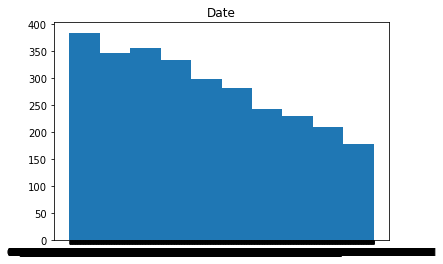

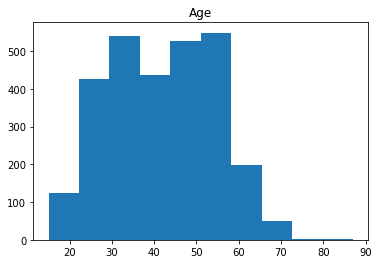

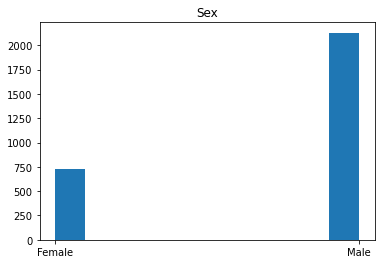

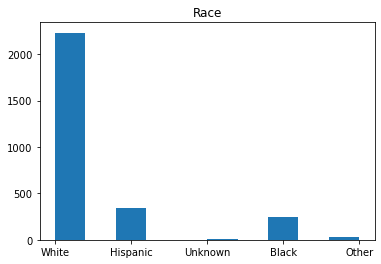

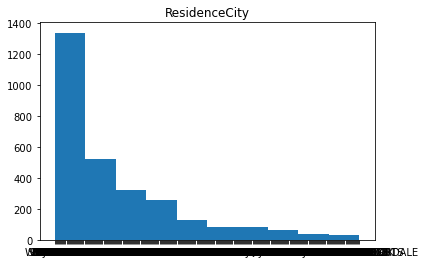

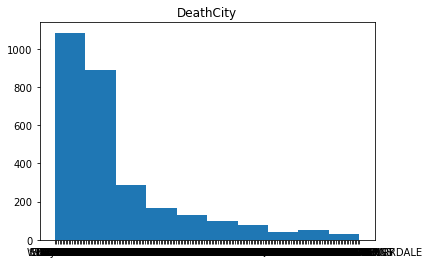

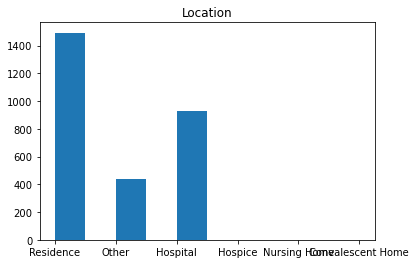

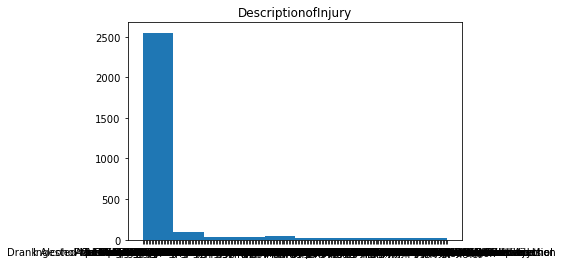

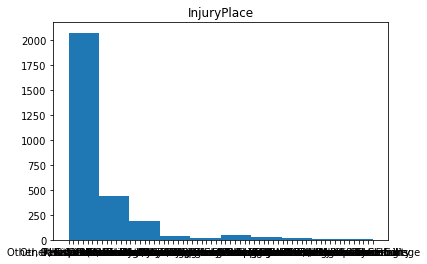

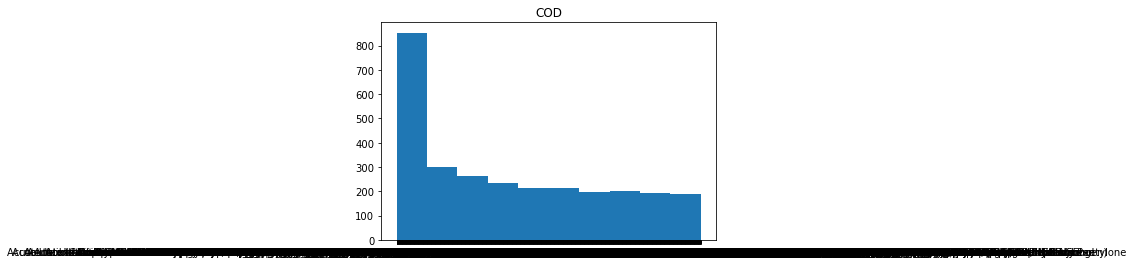

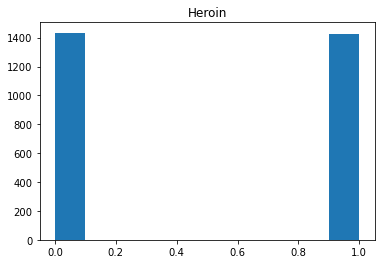

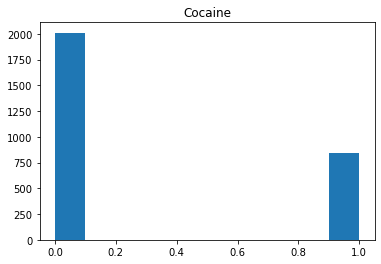

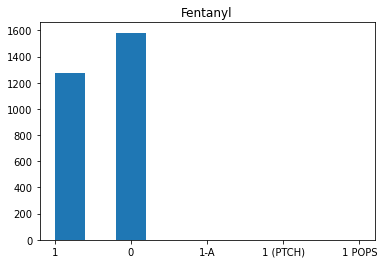

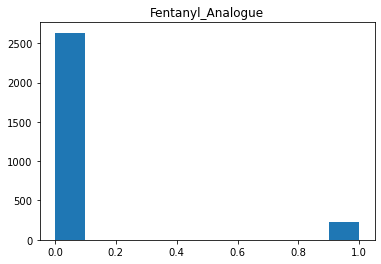

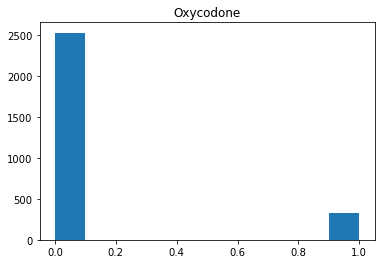

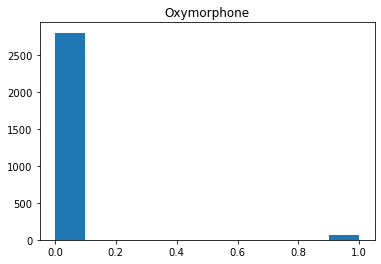

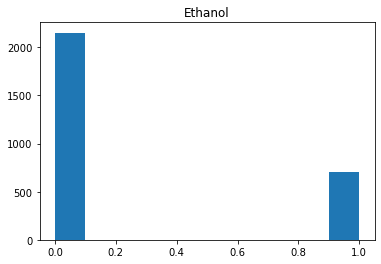

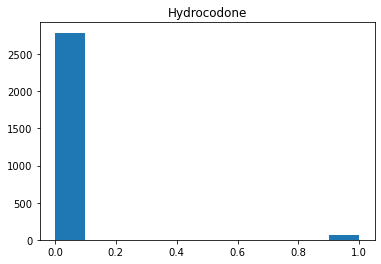

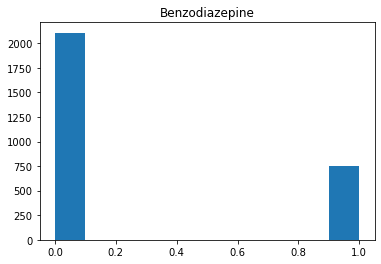

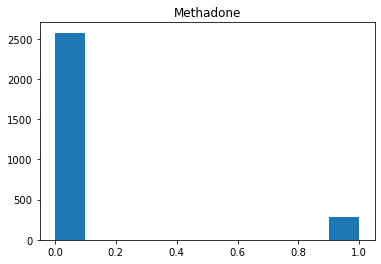

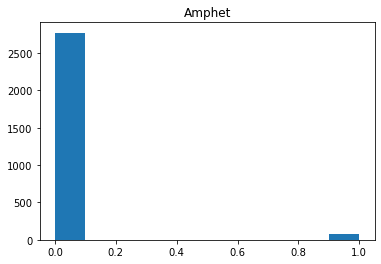

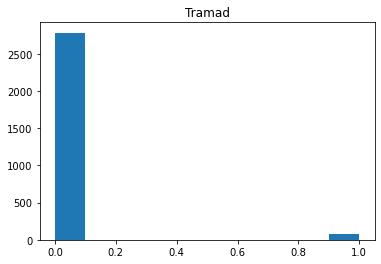

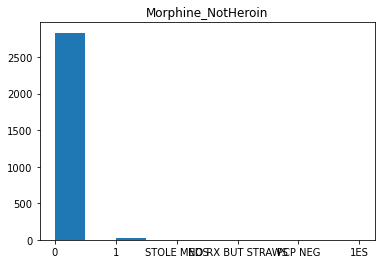

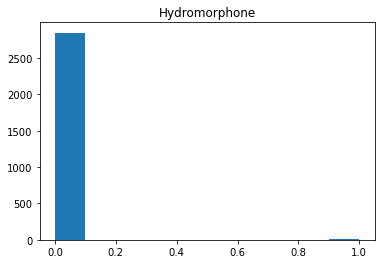

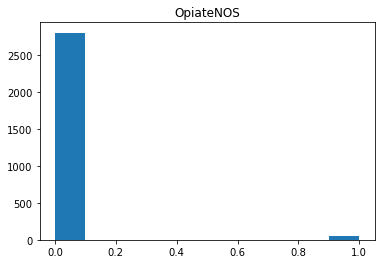

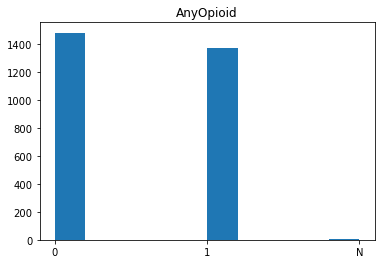

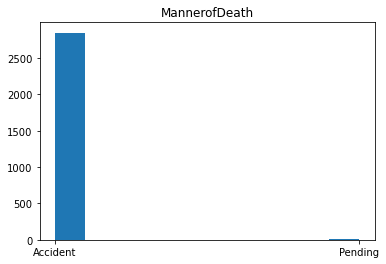

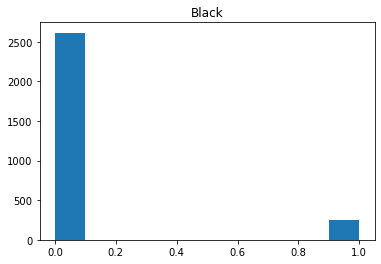

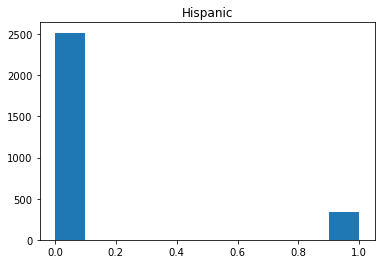

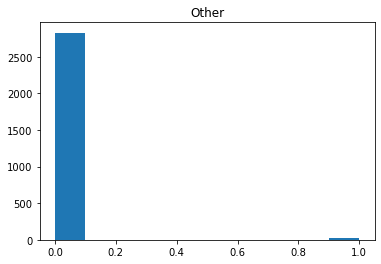

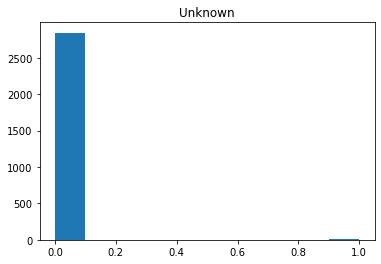

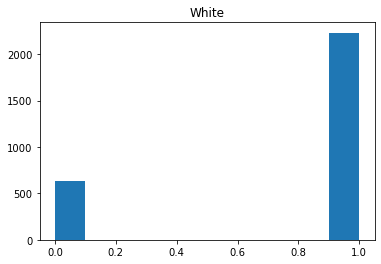

In [14]:
#visualize distribution
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

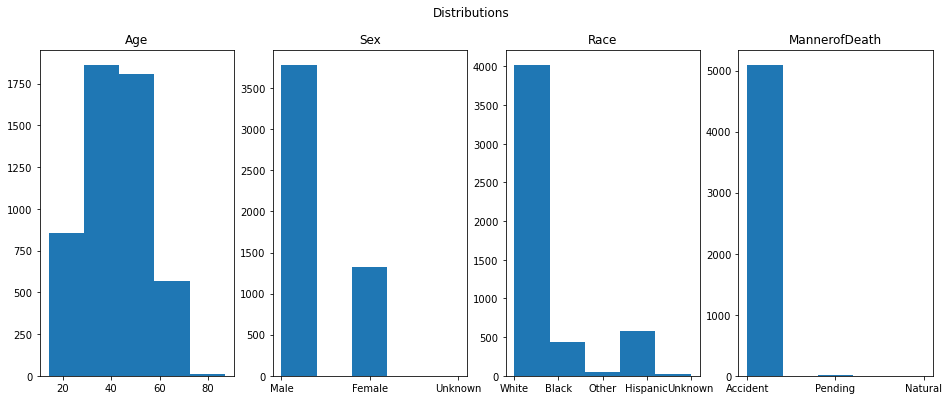

In [15]:
#specifically plot columns of interest

# Plot the distributions
plt.figure(figsize=(16, 6))

# List of columns
cols = ['Age', 'Sex', 'Race', 'MannerofDeath']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    plt.suptitle('Distributions')


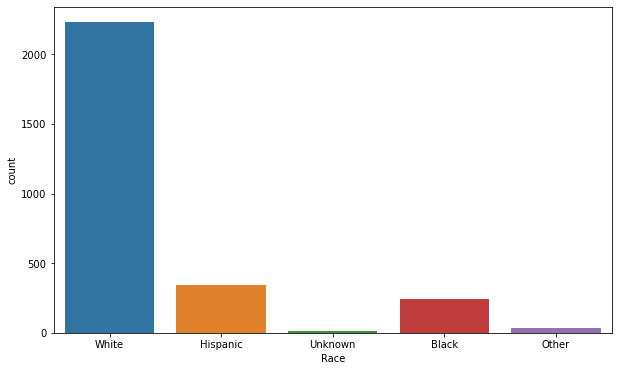

In [16]:
#visualize Race data using a countplot
plt.figure(figsize=(10,6))
sns.countplot(x='Race', data=train)
plt.show()

_________________________________

### Bivariate Exploration

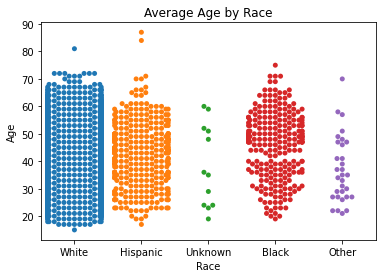

In [17]:
#plot age and race
sns.swarmplot(x= train.Race, y = train.Age)
plt.title('Average Age by Race')
None

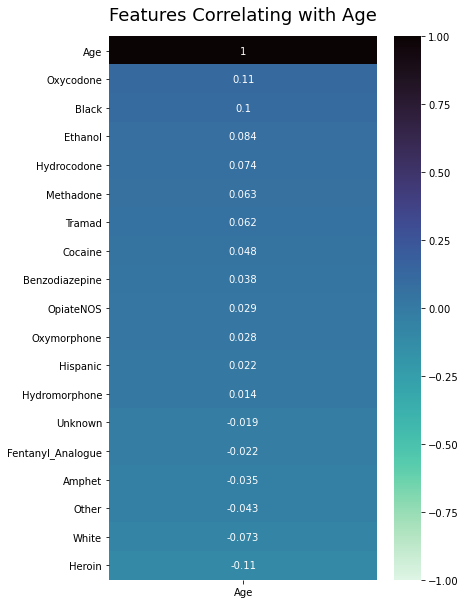

In [18]:
#visualize correlation with Age using Heatmap
plt.figure(figsize=(6, 10))
heatmap = sns.heatmap(train.corr()[['Age']].sort_values(by='Age', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with Age', fontdict={'fontsize':18}, pad=16);

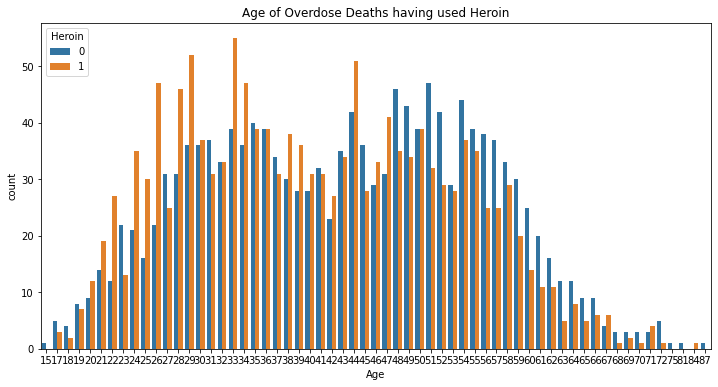

In [19]:
#visualize Age and Herion deaths data using a countplot
plt.figure(figsize=(12,6))
sns.countplot(x='Age', data=train, hue='Heroin')
plt.title('Age of Overdose Deaths having used Heroin')
plt.show()

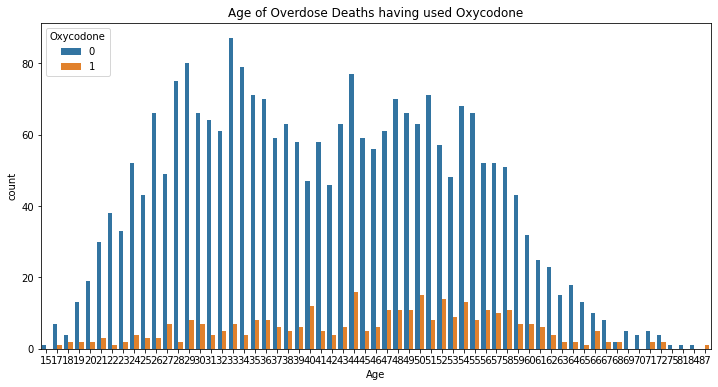

In [20]:
#visualize Age and Oxycodone deaths data using a countplot
plt.figure(figsize=(12,6))
sns.countplot(x='Age', data=train, hue='Oxycodone')
plt.title('Age of Overdose Deaths having used Oxycodone')
plt.show()

______________________

### Multivariate Exploration

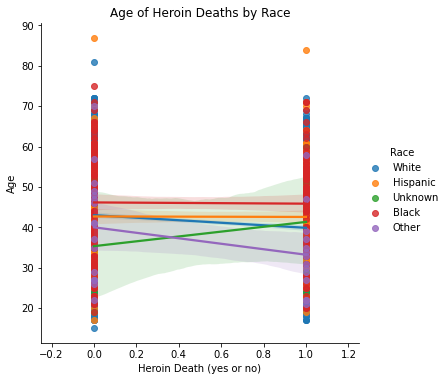

In [21]:
#visualize heroin deaths by age and race
sns.lmplot(x='Heroin', y='Age', hue='Race', data=train)
plt.title('Age of Heroin Deaths by Race')
plt.ylabel('Age')
plt.xlabel('Heroin Death (yes or no)')
plt.xlim(-0.25, 1.25)
None

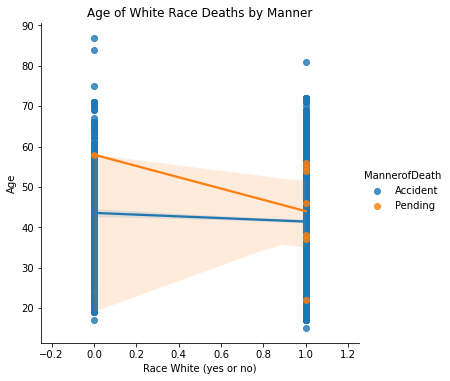

In [22]:
#visualize heroin deaths by age and race
sns.lmplot(x='White', y='Age', hue='MannerofDeath', data=train)
plt.title('Age of White Race Deaths by Manner')
plt.ylabel('Age')
plt.xlabel('Race White (yes or no)')
plt.xlim(-0.25, 1.25)
None

### Takeaways from Explore

- Heroin, Oxycodone, Black (race) have the strongest correlation with age
- The vast majority of drug overdose deaths appear to be among the white race in this dataset
- Heroin deaths peak around age 33
- Oxycodone deaths peak arond age 44
- Hispanic race appears to have the eldest drug overdose death (age 87)
- White race appears to have the youngest drug overdose death (age 14)

<hr style="border:1px solid black"> </hr>

## Hypothesis Testing

**Hypothesis 1: T-Test (continuous vs discrete)**
- $H_0$: There is a relationship between Age and White Race drug overdose deaths
- $H_a$: There is not a relationship between Age and With Race drug overdose deaths

In [23]:
#set alpha
alpha = .05

In [24]:
#sample size, must be more then 30 to meet assumption
train.Age.count(), train.White.count()

(2858, 2858)

In [25]:
#check variance
train.Age.var(), train.White.var()

#this shows not equal varient

(149.8752585634879, 0.17151102481646124)

In [26]:
#t-test on entire train set
t, p = stats.ttest_ind(train.Age,train.White, equal_var=False)
t,p

(179.4934639776462, 0.0)

In [27]:
hypothesis_df = pd.DataFrame(data=[{
    'Hypothesis': '#1',
    'p-value': (round(p,4)),
    't-value': (round(t,3)),
    'r-value': 'N/A',
    'alpha': alpha,
    'Result': 'fail to reject $H_o$'
    }])

hypothesis_df

,Hypothesis,p-value,t-value,r-value,alpha,Result
0,#1,0.0,179.493,N/A,0.05,fail to reject $H_o$


_______________________

**Hypothesis 2: T-Test (continuous vs discrete)**
- $H_0$: There is a relationship between Age and Oxycodone drug overdose deaths
- $H_a$: There is not a relationship between Age and Oxycodone drug overdose deaths

In [28]:
# sample size, must be more then 30 to meet assumption
train.Age.count(), train.Oxycodone.count()

(2858, 2858)

In [29]:
#check variance
train.Age.var(), train.Oxycodone.var()

#this shows not equal varient

(149.8752585634879, 0.10189954914120247)

In [30]:
#t-test on entire train set
t, p = stats.ttest_ind(train.Age,train.Oxycodone, equal_var=False)
t,p

(182.4387259159486, 0.0)

In [31]:
hypothesis_df = hypothesis_df.append(
    {
    'Hypothesis': '#2',
    'p-value': (round(p,4)),
    't-value': (round(t,4)),
    'r-value': 'N/A',
    'alpha': alpha,
    'Result': 'fail to reject $H_o$'},
    ignore_index= True
    )

hypothesis_df

,Hypothesis,p-value,t-value,r-value,alpha,Result
0,#1,0.0,179.4930,N/A,0.05,fail to reject $H_o$
1,#2,0.0,182.4387,N/A,0.05,fail to reject $H_o$


_____________________________

**Hypothesis 3: T-Test (continuous vs discrete)**
- $H_0$: There is a relationship between Age and Heroin drug overdose deaths
- $H_a$: There is not a relationship between Age and Heroin drug overdose deaths

In [32]:
# sample size, must be more then 30 to meet assumption
train.Age.count(), train.Heroin.count()

(2858, 2858)

In [33]:
#check variance
train.Age.var(), train.Heroin.var()

#this shows not equal varient

(149.8752585634879, 0.25008444264060153)

In [34]:
#t-test on entire train set
t, p = stats.ttest_ind(train.Age,train.Heroin, equal_var=False)
t,p

(180.67697239575637, 0.0)

In [35]:
hypothesis_df = hypothesis_df.append(
    {
    'Hypothesis': '#2',
    'p-value': (round(p,4)),
    't-value': (round(t,4)),
    'r-value': 'N/A',
    'alpha': alpha,
    'Result': 'fail to reject $H_o$'},
    ignore_index= True
    )

hypothesis_df

,Hypothesis,p-value,t-value,r-value,alpha,Result
0,#1,0.0,179.4930,N/A,0.05,fail to reject $H_o$
1,#2,0.0,182.4387,N/A,0.05,fail to reject $H_o$
2,#2,0.0,180.6770,N/A,0.05,fail to reject $H_o$


__________________________

**Hypothesis 4: $X^2$ Test (discrete vs discrete)**
- $H_0$: There is a relationship between Heroin and Oxycodone drug overdose deaths
- $H_a$: There is not a relationship between Heroin and Oxycodone drug overdose deaths

In [36]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

In [37]:
x= train.Heroin
y= train.Oxycodone

In [38]:
r, p = stats.pearsonr(x,y)

In [39]:
hypothesis_df = hypothesis_df.append(
    {
    'Hypothesis': '#4',
    'p-value': (round(p,4)),
    't-value': 'N/A',
    'r-value': (round(r,4)),
    'alpha': alpha,
    'Result': 'reject $H_o$'},
    ignore_index= True
    )

hypothesis_df

,Hypothesis,p-value,t-value,r-value,alpha,Result
0,#1,0.0,179.493,N/A,0.05,fail to reject $H_o$
1,#2,0.0,182.439,N/A,0.05,fail to reject $H_o$
2,#2,0.0,180.677,N/A,0.05,fail to reject $H_o$
3,#4,0.0,N/A,-0.2213,0.05,reject $H_o$


### Takeaways from Hypothesis
- I failed to reject $H_0$ #1. Suggesting that there is a relation between age and white race drug overdose deaths
- I failed to reject $H_0$ #2. Suggesting that there is a relation between age and Oxycodone drug overdose deaths
- I failed to reject $H_0$ #3. Suggesting that there is a relation between age and Heroin drug overdose deaths
- I rejected  $H_0$ #4. Suggesting that there is no relationship between Heroin and Oxycodone drug overdose deaths

<hr style="border:2px solid black"> </hr>

# Model

In [40]:
#take a look at X_train dataframe
X_train.head()

,Date,Sex,Race,ResidenceCity,DeathCity,Location,DescriptionofInjury,InjuryPlace,COD,Heroin,...,Morphine_NotHeroin,Hydromorphone,OpiateNOS,AnyOpioid,MannerofDeath,Black,Hispanic,Other,Unknown,White
2570,07/11/2017 12:00:00 AM,Female,White,SUFFIELD,SUFFIELD,Residence,Substance Abuse,Residence,Acute Intoxication due to the Combined Effects...,1,...,0,0,0,0,Accident,0,0,0,0,1
2415,01/29/2017 12:00:00 AM,Female,White,COVENTRY,COVENTRY,Residence,Prescription Medicine Abuse,Residence,Acute Intoxication From the Combined Effects o...,0,...,1,1,0,0,Accident,0,0,0,0,1
4289,10/07/2018 12:00:00 AM,Male,White,STRATFORD,STRATFORD,Residence,Substance Abuse,Residence,Acute Intoxication From the Combined Effects o...,0,...,0,0,0,1,Accident,0,0,0,0,1
4620,02/03/2017 12:00:00 AM,Male,White,WINCHESTER,WINCHESTER,Residence,SUBSTANCE ABUSE,Residence,"ACUTE HEROIN, FENTANYL AND COCAINE TOXICITIES,...",1,...,0,0,0,0,Accident,0,0,0,0,1
2996,01/05/2017 12:00:00 AM,Male,White,DANBURY,DANBURY,Residence,Substance Abuse,Residence,Acute Fentanyl Intoxication,0,...,0,0,0,0,Accident,0,0,0,0,1


## Create Baseline

In [41]:
#create a baseline
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [42]:
# 1. Predict assessed_value_pred_mean

#predicted mean will be the mean of value_assessed column
age_pred_mean = y_train['Age'].mean()
#new column created
y_train['age_pred_mean'] = age_pred_mean
y_validate['age_pred_mean'] = age_pred_mean

In [43]:
y_train.head()

,Age,age_pred_mean
2570,27,41.907628
2415,61,41.907628
4289,24,41.907628
4620,47,41.907628
2996,23,41.907628


In [44]:
# 2. RMSE of value_assessed_pred_mean

#root mean squared error of the predicted mean
rmse_train = mean_squared_error(y_train.Age, y_train.age_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.Age, y_validate.age_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 3), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 3))

RMSE using Mean
Train/In-Sample:  12.24 
Validate/Out-of-Sample:  12.536


In [45]:
#create a dataframe to make data easier to visualize/understand
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_train': (round(rmse_train,3)),
    'rmse_validate': (round(rmse_validate,3)),
    'r^2': (round(explained_variance_score(y_validate.Age, y_validate.age_pred_mean),3))}])

metric_df
#we now have out baseline model to work off of

,model,rmse_train,rmse_validate,r^2
0,mean_baseline,12.24,12.536,0.0


_________________________

## OLS Model

In [46]:
#set X_train to drivers only
#we do not want to include all columns in this because it could cause overfitting
#these two features have the highest correlation
drivers_train = X_train[['Oxycodone', 'Heroin']]

#set X_validate_scaled to drivers only
drivers_validate= X_validate[['Oxycodone', 'Heroin']]

#set X_test_scaled to drivers only
drivers_test= X_test[['Oxycodone', 'Heroin']]

In [47]:
#create the model 
lm = LinearRegression(normalize=True)

#fit
lm.fit(drivers_train, y_train.Age)

LinearRegression(normalize=True)

In [48]:
# predict train
y_train['age_pred_lm'] = lm.predict(drivers_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Age, y_train.age_pred_lm)**(1/2)

# predict validate
y_validate['age_pred_lm'] = lm.predict(drivers_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Age, y_validate.age_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  12.118785439335973 
Validation/Out-of-Sample:  12.380931745188388


In [49]:
#create visual to see baseline vs LinearRegression model
metric_df = metric_df.append(
    {
    'model': 'OLS',
    'rmse_train': (round(rmse_train,3)),
    'rmse_validate': (round(rmse_validate,3)),
    'r^2': (round(explained_variance_score(y_validate.Age, y_validate.age_pred_lm),3))}, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate,r^2
0,mean_baseline,12.240,12.536,0.000
1,OLS,12.119,12.381,0.024


_____________________

## Lasso Lars Model

In [50]:
# create the model object
lars = LassoLars(alpha= 2)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(drivers_train, y_train.Age)

# predict train
y_train['age_pred_lars'] = lars.predict(drivers_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Age, y_train.age_pred_lars)**(1/2)

# predict validate
y_validate['age_pred_lars'] = lars.predict(drivers_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Age, y_validate.age_pred_lars)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  12.240213149907696 
Validation/Out-of-Sample:  12.535506516301341


In [51]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'LassoLars (alpha 2)',
    'rmse_train': (round(rmse_train,3)),
    'rmse_validate': (round(rmse_validate,3)),
    'r^2': (round(explained_variance_score(y_validate.Age, y_validate.age_pred_lars),3))}, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate,r^2
0,mean_baseline,12.240,12.536,0.000
1,OLS,12.119,12.381,0.024
2,LassoLars (alpha 2),12.240,12.536,0.000


______________

## Tweedie Regressor Model

In [52]:
# create the model object
glm = TweedieRegressor(power=1, alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(drivers_train, y_train.Age)

# predict train
y_train['age_pred_glm'] = glm.predict(drivers_train)

# evaluate: rmse
rmse_train = (mean_squared_error(y_train.Age, y_train.age_pred_glm)**(1/2))

# predict validate
y_validate['age_pred_glm'] = glm.predict(drivers_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Age, y_validate.age_pred_glm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  12.120790963696876 
Validation/Out-of-Sample:  12.383584360786044


In [53]:
#compares all four models
metric_df = metric_df.append(
    {
    'model': 'TweedieRegressor (power 1, alpha 2)',
    'rmse_train': (round(rmse_train,3)),
    'rmse_validate': (round(rmse_validate,3)),
    'r^2': (round(explained_variance_score(y_validate.Age, y_validate.age_pred_glm),3))}, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate,r^2
0,mean_baseline,12.240,12.536,0.000
1,OLS,12.119,12.381,0.024
2,LassoLars (alpha 2),12.240,12.536,0.000
3,"TweedieRegressor (power 1, alpha 2)",12.121,12.384,0.024


____________________

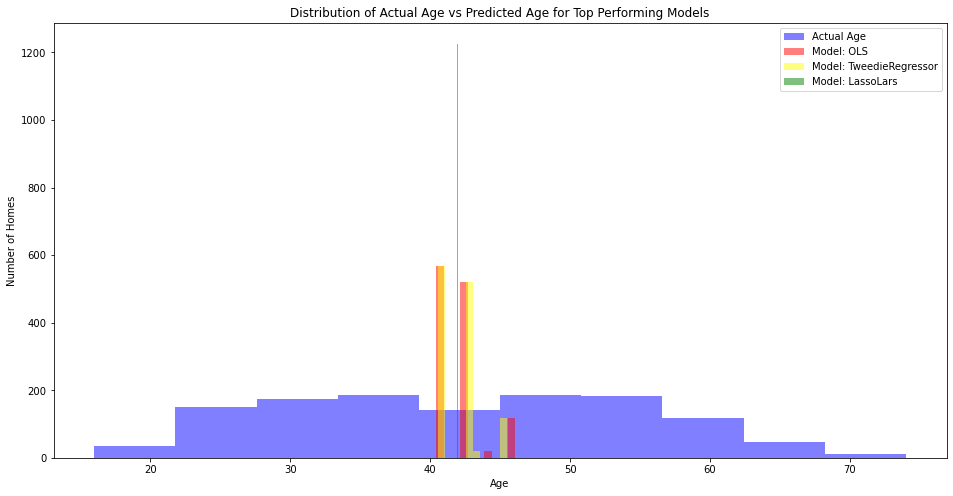

In [54]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.Age, color='blue', alpha=.5, label="Actual Age")
plt.hist(y_validate.age_pred_lm, color='red', alpha=.5, label="Model: OLS")
plt.hist(y_validate.age_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.age_pred_lars, color='green', alpha=.5, label="Model: LassoLars")
plt.xlabel("Age")
plt.ylabel("Number of Homes")
plt.title("Distribution of Actual Age vs Predicted Age for Top Performing Models")
plt.legend()
plt.show()

____________________

### Use Test set on Best Performing Model

In [55]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['age_pred_lm'] = lm.predict(drivers_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.Age, y_test.age_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  12.087717914301749


### Takeaways from Modeling:
- OLS model performs better than the baseline and other predictive models
- The drop of between train and validate was not significant

<hr style="border:2px solid black"> </hr>

## Final Takeaways and Next Steps:

- OLS Model performed the best, outperforming the baseline and other models
- Average age does not appear to change significantly
- All $H_0$ were reject with the exception of one

<br>

- With more time, I would like to:
    - continue looking into my Time Series project available here: [Github Repo](https://github.com/natasharivers/individual_project/blob/main/Initial%20Time%20Series%20Notebook.ipynb)
        - Does average age change over time?
        - Do Heroin deaths increase over time?
        
<br>

- I would like to see more data
    - possibly from other areas and 
    - more recent years (2020 and 2021)